In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
import time
import xgboost as xgb

In [2]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


## Auxiliary functions

In [3]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    #mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    wape = mae / np.abs(actuals).mean() * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    #print('MSE: %.4f' % mse)
    #print('RMSE: %.4f' % rmse)
    #print('MAE: %.4f' % mae)
    #print('WMAPE: %.4f' % wmape)
    print('WAPE: %.4f' % wape)
    #print('R2: %.4f' % r2)
    return mse, rmse, mae, wape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train.values.ravel())
    preds = model.predict(X_test)
    scores = cross_validate(estimator, X_train, y_train.values.ravel(), scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
    return model, preds, scores

In [4]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged RMSE: {}".format(np.round(sum(j for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAE: {}".format(np.round(sum(k for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))


def last_energy_points(df, number_timesteps):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df.shift(i)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y = pd.DataFrame(df[number_timesteps:])
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

def build_predict_show(df, number_timesteps, estimator, normalize=False, train_size=0.8, start_timestep=1 ):
    full_start = time.time()
    metrics_list = []
    for i in range(start_timestep,(number_timesteps + 1)):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df, i)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        if(normalize):
            scaler = MinMaxScaler().fit(X_train)
            X_train_norm = scaler.transform(X_train)
            X_test_norm = scaler.transform(X_test)
        model, preds, scores = build_model(estimator, X_train, y_train, X_test)
        mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values.reshape(-1))
        cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),5)
        cv_rmse = np.round(scores['test_neg_root_mean_squared_error'].mean() * (-1),5)
        cv_mae = np.round(scores['test_neg_mean_absolute_error'].mean() * (-1),5)
        cv_r2 = np.round(scores['test_r2'].mean(),3)
        print("CV MSE: {} ".format(cv_mse))
        print("CV RMSE: {} ".format(cv_rmse))
        print("CV MAE: {} ".format(cv_mae))
        print("CV R2: {} ".format(cv_r2))
        metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))
    return model, preds, scores, metrics_list

def split_train_test_timeseries(X, y, train_size: int):
    n_train_samples = int(len(X) * train_size)
    X_train = X[:n_train_samples]
    X_test = X[n_train_samples:]
    y_train = y[:n_train_samples]
    y_test = y[n_train_samples:]
    return X_train, X_test, y_train, y_test

def show_graphic_per_timestep(metrics_list, number_timesteps, start_timestep=1):
    mse_list = []
    rmse_list = []
    mae_list = []
    wape_list = []
    r2_list = []

    for i in range(0,len(metrics_list)):
        mse_list.append(metrics_list[i][0])
        rmse_list.append(metrics_list[i][1])
        mae_list.append(metrics_list[i][2])
        wape_list.append(metrics_list[i][3])
        r2_list.append(metrics_list[i][4])
        
    plt.plot(range(start_timestep,(number_timesteps+1)), mse_list)
    plt.title('MSE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('MSE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), rmse_list)
    plt.title('RMSE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('RMSE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), mae_list)
    plt.title('MAE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('MAE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), wape_list)
    plt.title('WAPE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('WAPE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), r2_list)
    plt.title('R2 per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('R2')
    plt.show()
    

In [5]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35131,49.211311
35132,43.139892
35133,44.599341
35134,28.956084


## Preprocessing

In [6]:
X,y = last_energy_points(df_total, 8)
print(X.shape, y.shape)
X

(35128, 8) (35128, 1)


,Energy_15,Energy_30,Energy_45,Energy_60,Energy_75,Energy_90,Energy_105,Energy_120
0,49.966228,50.544573,63.710440,63.404029,62.735722,63.011688,57.575249,58.514142
1,50.950286,49.966228,50.544573,63.710440,63.404029,62.735722,63.011688,57.575249
2,53.039862,50.950286,49.966228,50.544573,63.710440,63.404029,62.735722,63.011688
3,50.620055,53.039862,50.950286,49.966228,50.544573,63.710440,63.404029,62.735722
4,53.267193,50.620055,53.039862,50.950286,49.966228,50.544573,63.710440,63.404029
...,...,...,...,...,...,...,...,...
35123,62.642645,39.394640,42.250176,46.691361,46.176803,66.271213,61.161247,75.527383
35124,49.211311,62.642645,39.394640,42.250176,46.691361,46.176803,66.271213,61.161247
35125,43.139892,49.211311,62.642645,39.394640,42.250176,46.691361,46.176803,66.271213
35126,44.599341,43.139892,49.211311,62.642645,39.394640,42.250176,46.691361,46.176803


In [7]:
y

,Energy
0,50.950286
1,53.039862
2,50.620055
3,53.267193
4,54.280021
...,...
35123,49.211311
35124,43.139892
35125,44.599341
35126,28.956084


## Test model

### Gradient Boosting

In [8]:
start_timestep = 2
number_timesteps = 12

In [9]:
model_gb, preds_gb, scores_gb, metrics_list_gb = build_predict_show(df_total, number_timesteps, GradientBoostingRegressor(random_state=42), start_timestep=start_timestep)


Iteration  2
WAPE: 20.3166
CV MSE: 116.53514 
CV RMSE: 10.79421 
CV MAE: 7.60849 
CV R2: 0.716 

Elapsed time: 9.724 seconds

Iteration  3
WAPE: 19.1954
CV MSE: 117.42523 
CV RMSE: 10.83562 
CV MAE: 7.66527 
CV R2: 0.719 

Elapsed time: 13.709 seconds

Iteration  4
WAPE: 19.9350
CV MSE: 114.66805 
CV RMSE: 10.70779 
CV MAE: 7.58557 
CV R2: 0.724 

Elapsed time: 19.105 seconds

Iteration  5
WAPE: 19.5310
CV MSE: 115.2768 
CV RMSE: 10.73625 
CV MAE: 7.5951 
CV R2: 0.722 

Elapsed time: 23.536 seconds

Iteration  6
WAPE: 19.3994
CV MSE: 117.05182 
CV RMSE: 10.81841 
CV MAE: 7.64107 
CV R2: 0.721 

Elapsed time: 26.835 seconds

Iteration  7
WAPE: 19.2529
CV MSE: 116.91546 
CV RMSE: 10.81214 
CV MAE: 7.64645 
CV R2: 0.721 

Elapsed time: 30.972 seconds

Iteration  8
WAPE: 19.6218
CV MSE: 116.67119 
CV RMSE: 10.80028 
CV MAE: 7.60293 
CV R2: 0.722 

Elapsed time: 36.369 seconds

Iteration  9
WAPE: 19.4352
CV MSE: 116.81977 
CV RMSE: 10.80799 
CV MAE: 7.62438 
CV R2: 0.718 

Elapsed time: 42

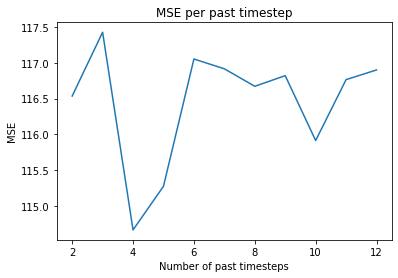

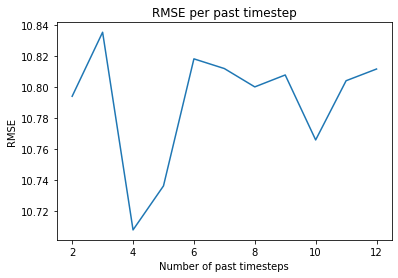

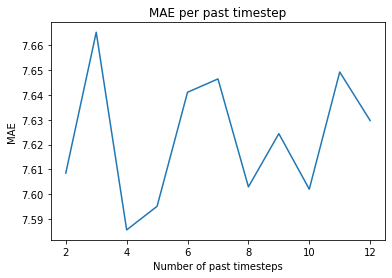

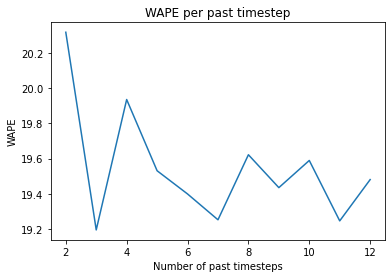

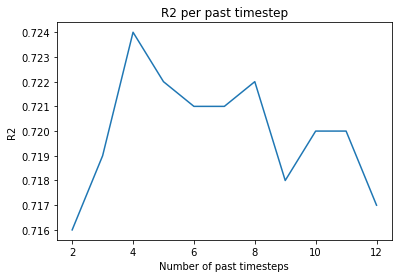

In [10]:
show_graphic_per_timestep(metrics_list_gb, number_timesteps, start_timestep)

#### Normalized

In [11]:
model_gb_norm, preds_gb_norm, scores_gb_norm, metrics_list_gb_norm = build_predict_show(df_total, number_timesteps, GradientBoostingRegressor(random_state=42), normalize=True, start_timestep=start_timestep)


Iteration  2
WAPE: 19.8037
CV MSE: 119.20053 
CV RMSE: 10.91756 
CV MAE: 7.70016 
CV R2: 0.714 

Elapsed time: 9.793 seconds

Iteration  3
WAPE: 19.8150
CV MSE: 115.9001 
CV RMSE: 10.76496 
CV MAE: 7.60112 
CV R2: 0.721 

Elapsed time: 13.726 seconds

Iteration  4
WAPE: 19.7733
CV MSE: 115.35032 
CV RMSE: 10.73998 
CV MAE: 7.58618 
CV R2: 0.722 

Elapsed time: 18.247 seconds

Iteration  5
WAPE: 19.6786
CV MSE: 114.69139 
CV RMSE: 10.70865 
CV MAE: 7.57737 
CV R2: 0.724 

Elapsed time: 24.947 seconds

Iteration  6
WAPE: 19.7394
CV MSE: 115.62012 
CV RMSE: 10.75117 
CV MAE: 7.59475 
CV R2: 0.722 

Elapsed time: 27.571 seconds

Iteration  7
WAPE: 19.7241
CV MSE: 116.63919 
CV RMSE: 10.79853 
CV MAE: 7.61078 
CV R2: 0.723 

Elapsed time: 30.533 seconds

Iteration  8
WAPE: 19.8409
CV MSE: 115.6753 
CV RMSE: 10.75297 
CV MAE: 7.60923 
CV R2: 0.722 

Elapsed time: 35.311 seconds

Iteration  9
WAPE: 19.7782
CV MSE: 114.5398 
CV RMSE: 10.7018 
CV MAE: 7.56813 
CV R2: 0.721 

Elapsed time: 42.5

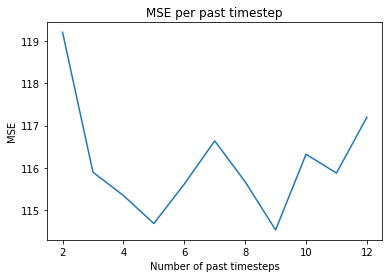

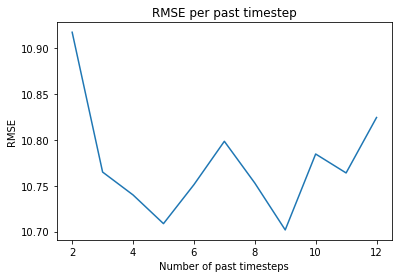

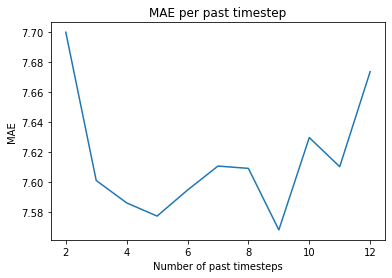

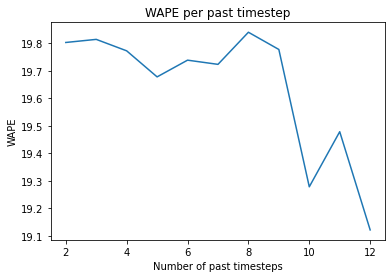

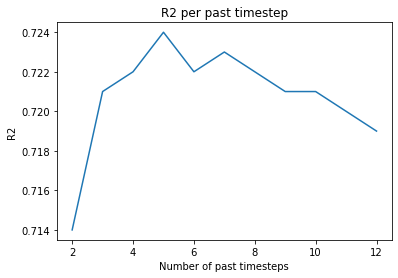

In [12]:
show_graphic_per_timestep(metrics_list_gb_norm, number_timesteps, start_timestep)

### Random Forest

In [13]:
model_rf, preds_rf, scores_rf, metrics_list_rf = build_predict_show(df_total, number_timesteps, RandomForestRegressor(random_state=42), start_timestep=start_timestep)


Iteration  2
MAPE: 21.8830
CV MSE: 139.309 
CV RMSE: 11.803 
CV MAE: 8.471 
CV R2: 0.664 

Elapsed time: 35.0 seconds

Iteration  3
MAPE: 20.6800
CV MSE: 129.731 
CV RMSE: 11.389 
CV MAE: 8.157 
CV R2: 0.686 

Elapsed time: 50.0 seconds

Iteration  4
MAPE: 20.5584
CV MSE: 126.334 
CV RMSE: 11.239 
CV MAE: 8.03 
CV R2: 0.694 

Elapsed time: 59.0 seconds

Iteration  5
MAPE: 20.3995
CV MSE: 123.476 
CV RMSE: 11.11 
CV MAE: 7.94 
CV R2: 0.701 

Elapsed time: 73.0 seconds

Iteration  6
MAPE: 20.2213
CV MSE: 122.24 
CV RMSE: 11.056 
CV MAE: 7.903 
CV R2: 0.704 

Elapsed time: 88.0 seconds

Iteration  7
MAPE: 20.0015
CV MSE: 122.681 
CV RMSE: 11.076 
CV MAE: 7.908 
CV R2: 0.705 

Elapsed time: 96.0 seconds

Iteration  8
MAPE: 20.2492
CV MSE: 121.537 
CV RMSE: 11.024 
CV MAE: 7.88 
CV R2: 0.707 

Elapsed time: 109.0 seconds

Iteration  9
MAPE: 20.3629
CV MSE: 119.061 
CV RMSE: 10.91 
CV MAE: 7.799 
CV R2: 0.712 

Elapsed time: 121.0 seconds

Iteration  10
MAPE: 19.9488
CV MSE: 120.264 
CV RMS

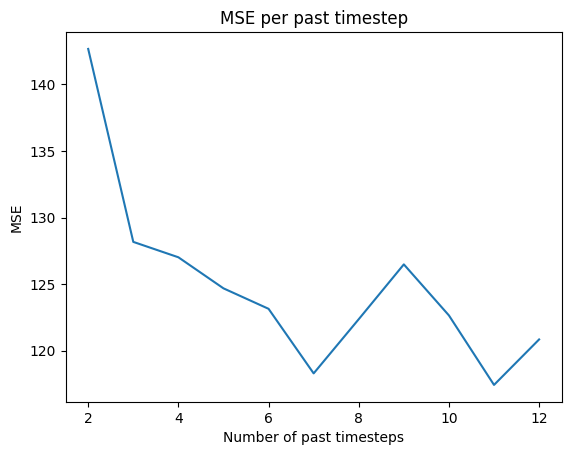

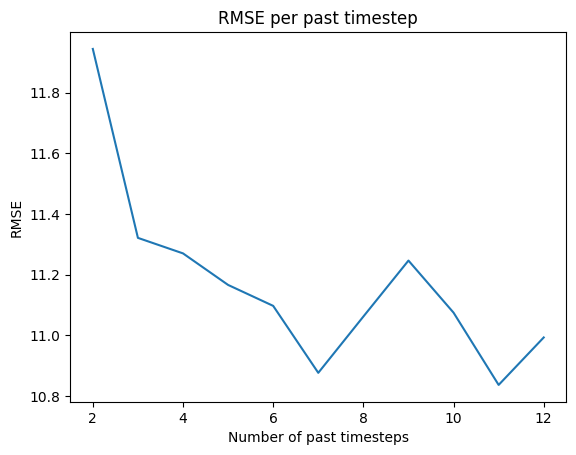

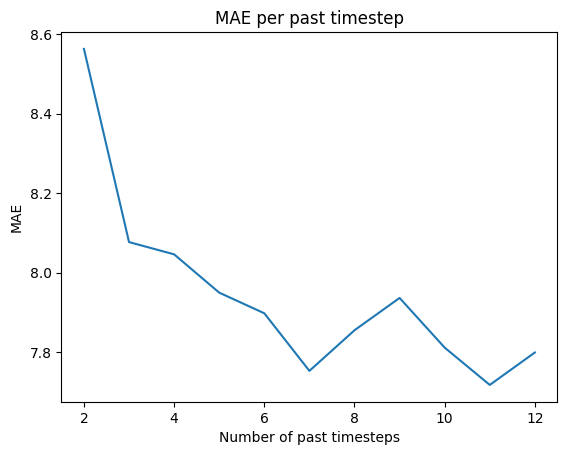

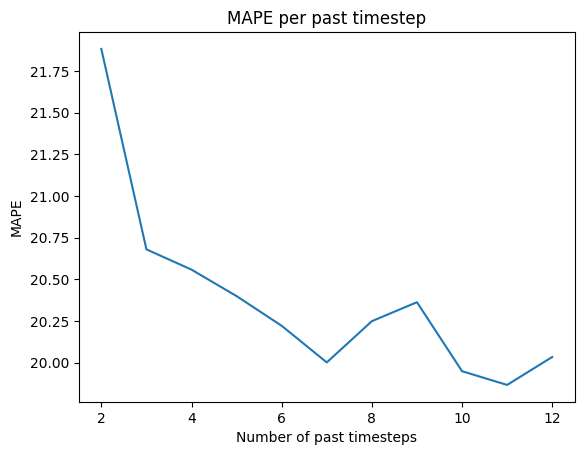

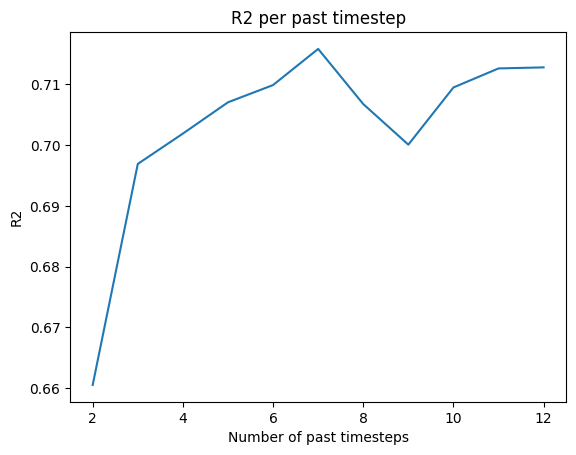

In [35]:
show_graphic_per_timestep(metrics_list_rf, number_timesteps, start_timestep=start_timestep)

#### Normalized

In [37]:
model_rf_norm, preds_rf_norm, scores_rf_norm, metrics_list_rf_norm = build_predict_show(df_total, number_timesteps, RandomForestRegressor(random_state=42), normalize=True, start_timestep=start_timestep)


Iteration  2
MAPE: 25.1259
CV MSE: 0.006 
CV RMSE: 0.074 
CV MAE: 0.053 
CV R2: 0.664 

Elapsed time: 32.0 seconds

Iteration  3
MAPE: 23.7577
CV MSE: 0.005 
CV RMSE: 0.072 
CV MAE: 0.051 
CV R2: 0.686 

Elapsed time: 47.0 seconds

Iteration  4
MAPE: 23.6208
CV MSE: 0.005 
CV RMSE: 0.071 
CV MAE: 0.051 
CV R2: 0.694 

Elapsed time: 62.0 seconds

Iteration  5
MAPE: 23.4290
CV MSE: 0.005 
CV RMSE: 0.07 
CV MAE: 0.05 
CV R2: 0.701 

Elapsed time: 78.0 seconds

Iteration  6
MAPE: 23.2329
CV MSE: 0.005 
CV RMSE: 0.07 
CV MAE: 0.05 
CV R2: 0.704 

Elapsed time: 91.0 seconds

Iteration  7
MAPE: 23.0129
CV MSE: 0.005 
CV RMSE: 0.07 
CV MAE: 0.05 
CV R2: 0.704 

Elapsed time: 102.0 seconds

Iteration  8
MAPE: 23.2867
CV MSE: 0.005 
CV RMSE: 0.07 
CV MAE: 0.05 
CV R2: 0.707 

Elapsed time: 117.0 seconds

Iteration  9
MAPE: 23.3982
CV MSE: 0.005 
CV RMSE: 0.069 
CV MAE: 0.049 
CV R2: 0.712 

Elapsed time: 125.0 seconds

Iteration  10
MAPE: 22.8959
CV MSE: 0.005 
CV RMSE: 0.069 
CV MAE: 0.049 
CV

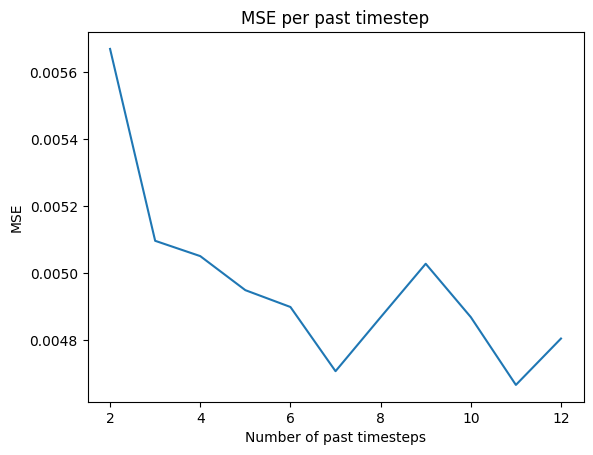

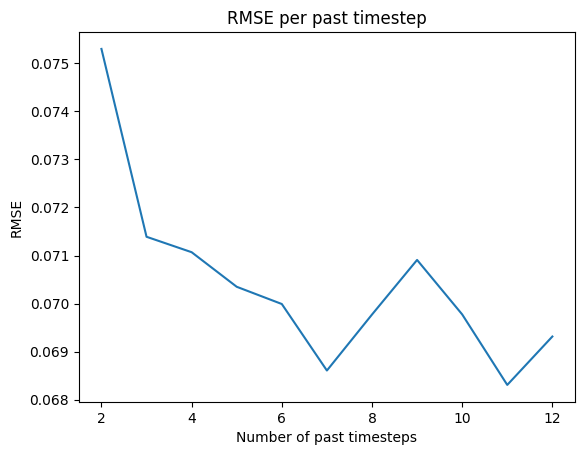

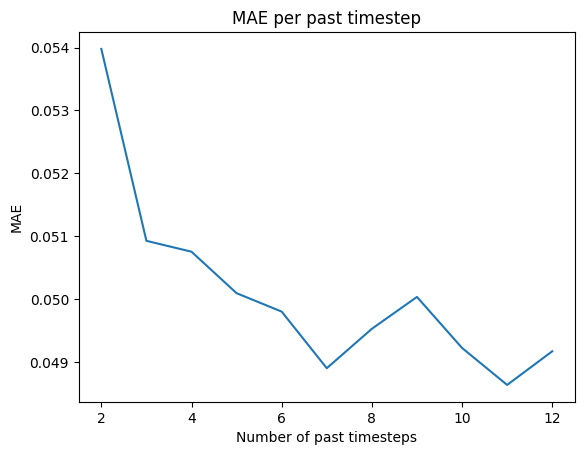

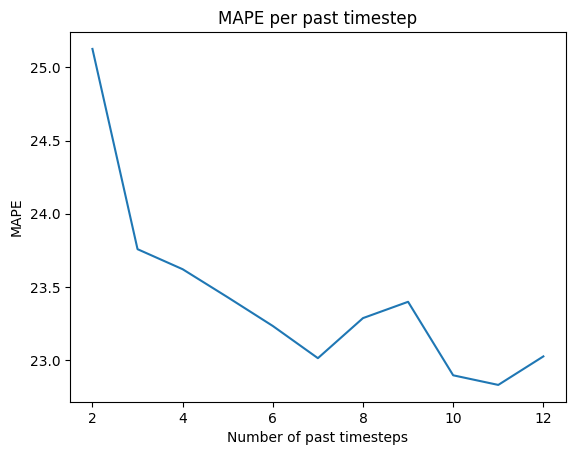

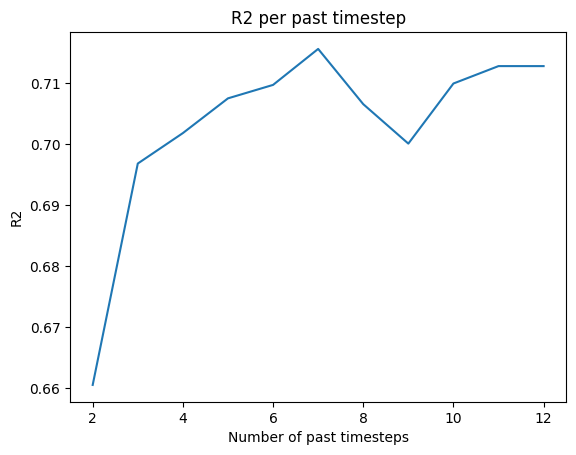

In [38]:
show_graphic_per_timestep(metrics_list_rf_norm, number_timesteps, start_timestep=start_timestep)

## XGBoost

In [13]:
model_xgb, preds_xgb, scores_xgb, metrics_list_xgb = build_predict_show(df_total, number_timesteps, xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, seed=42), start_timestep=start_timestep)


Iteration  30
WAPE: 19.3288
CV MSE: 115.91943 
CV RMSE: 10.7661 
CV MAE: 7.62104 
CV R2: 0.721 

Elapsed time: 23.733 seconds

Full Elapsed time: 23.733 seconds


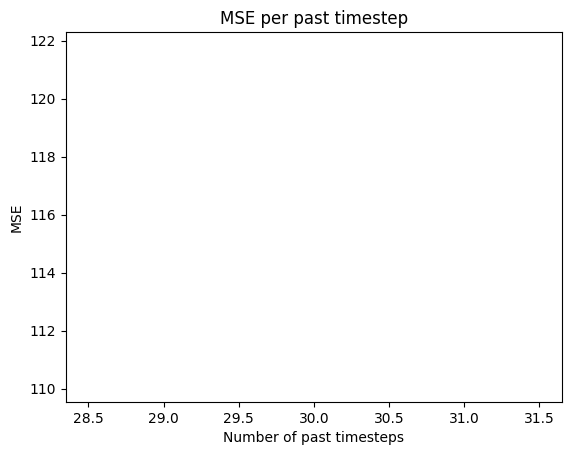

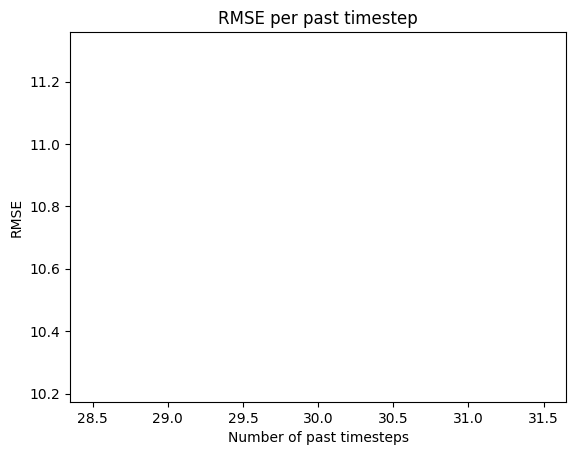

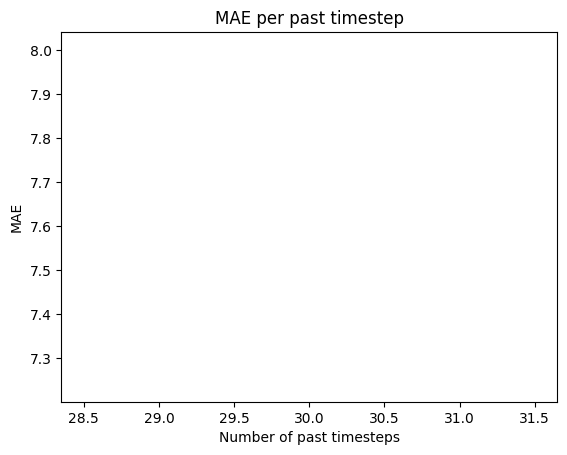

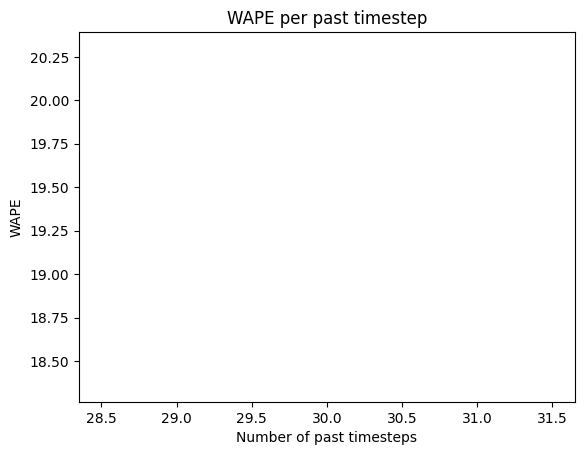

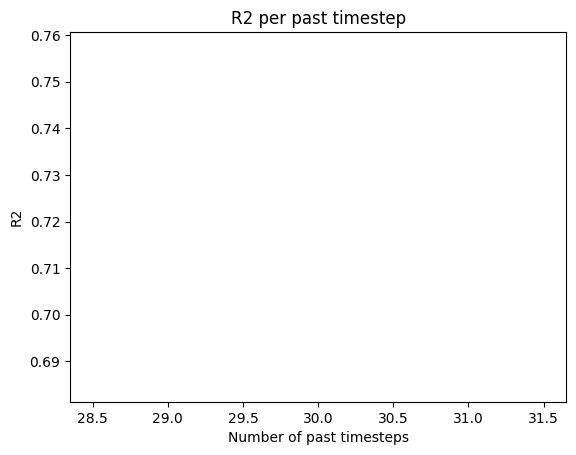

In [14]:
show_graphic_per_timestep(metrics_list_xgb, number_timesteps, start_timestep=start_timestep)

#### Normalized

In [41]:
model_xgb_norm, preds_xgb_norm, scores_xgb_norm, metrics_list_xgb_norm = build_predict_show(df_total, number_timesteps, xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, seed=42), normalize=True, start_timestep=start_timestep)


Iteration  2
MAPE: 22.8568
CV MSE: 0.005 
CV RMSE: 0.069 
CV MAE: 0.049 
CV R2: 0.712 

Elapsed time: 4.0 seconds

Iteration  3
MAPE: 22.2769
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.716 

Elapsed time: 5.0 seconds

Iteration  4
MAPE: 22.4845
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.717 

Elapsed time: 6.0 seconds

Iteration  5
MAPE: 22.4418
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.718 

Elapsed time: 6.0 seconds

Iteration  6
MAPE: 22.4983
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.719 

Elapsed time: 7.0 seconds

Iteration  7
MAPE: 22.3155
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.718 

Elapsed time: 7.0 seconds

Iteration  8
MAPE: 22.6236
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.719 

Elapsed time: 7.0 seconds

Iteration  9
MAPE: 22.6503
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R2: 0.722 

Elapsed time: 11.0 seconds

Iteration  10
MAPE: 22.1756
CV MSE: 0.005 
CV RMSE: 0.068 
CV MAE: 0.048 
CV R

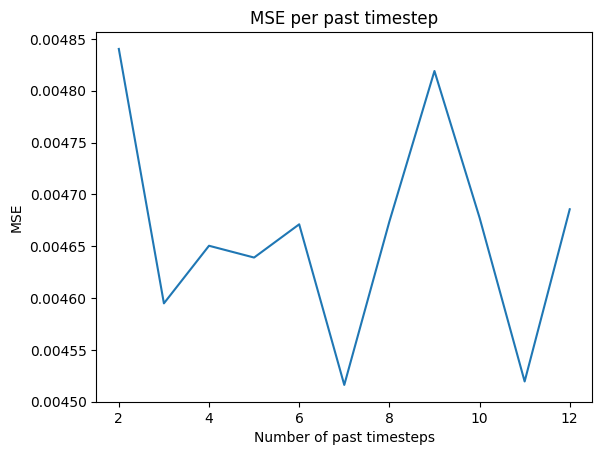

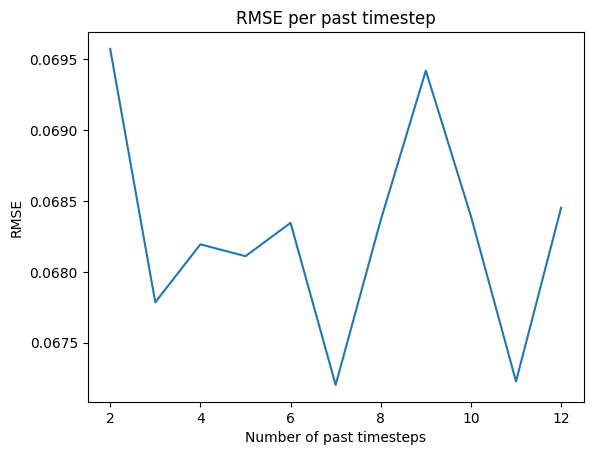

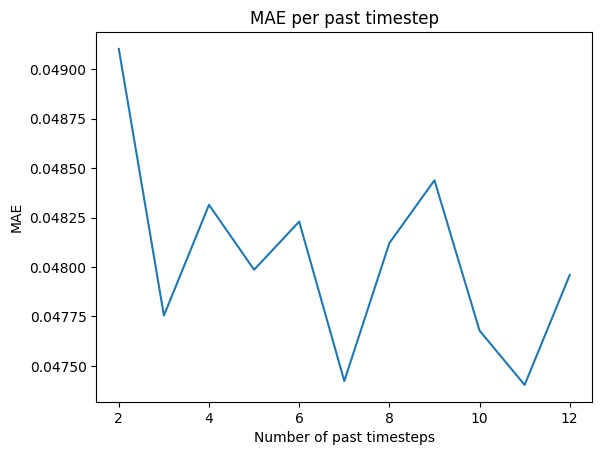

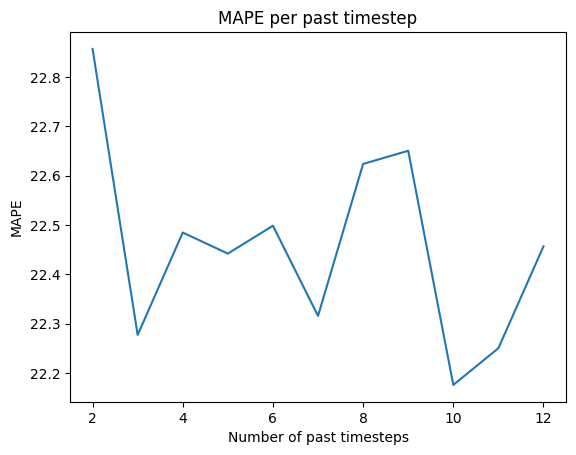

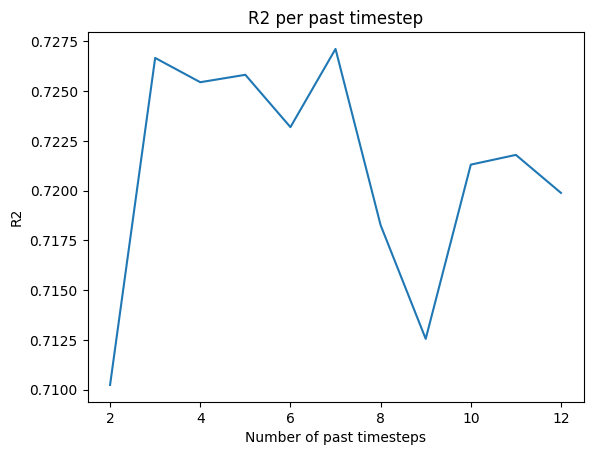

In [42]:
show_graphic_per_timestep(metrics_list_xgb_norm, number_timesteps, start_timestep=start_timestep)

In [15]:
print(min([sublist[3] for sublist in metrics_list_gb]))
#print(min([sublist[3] for sublist in metrics_list_gb_norm]))
#print(min([sublist[3] for sublist in metrics_list_rf]))
#print(min([sublist[3] for sublist in metrics_list_rf_norm]))
print(min([sublist[3] for sublist in metrics_list_xgb]))
#print(min([sublist[3] for sublist in metrics_list_xgb_norm]))

19.590544073768573
19.32884154295006


In [91]:
def switch_metric(metric: str):
    if metric.lower() == "mse":
        m = 0
    elif metric.lower() == "rmse":
        m = 1
    elif metric.lower() == "mae":
        m = 2
    elif metric.lower() == "wape":
        m = 3
    elif metric.lower() == "r2":
        m = 4
    return m

In [94]:
def find_best_model(metric: str, metrics_list):
    met = switch_metric(metric)
    min_value = min(map(lambda x: x[met], metrics_list))
    idx = [index for index, item in enumerate(map(lambda x: x[met], metrics_list)) if item == min_value]
    return metrics_list[idx[0]]

In [104]:
all_metrics_lists = [metrics_list_gb, metrics_list_gb_norm, metrics_list_rf, metrics_list_rf_norm, metrics_list_xgb, metrics_list_xgb_norm]

In [105]:
best_model = []
for model in all_metrics_lists:
    best_model.append(find_best_model("wape", model))

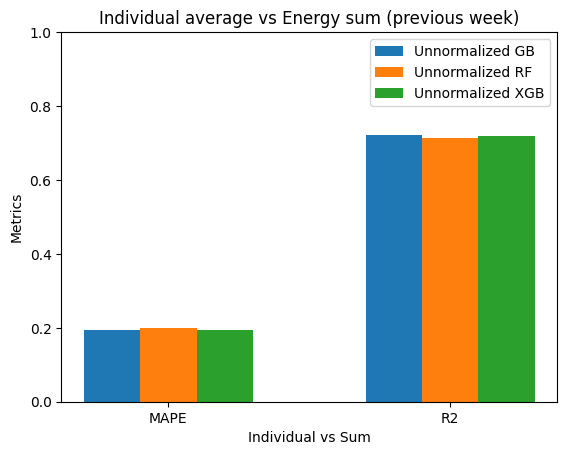

In [137]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[0][3], best_model[0][4]), 0.2, label = 'Denormalized GB')
plt.bar(X_axis, (best_model[2][3], best_model[2][4]), 0.2, label = 'Denormalized RF')
plt.bar(X_axis + 0.2, (best_model[4][3], best_model[4][4]), 0.2, label = 'Denormalized XGB')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.title("Denormalized")
plt.legend()
plt.show()

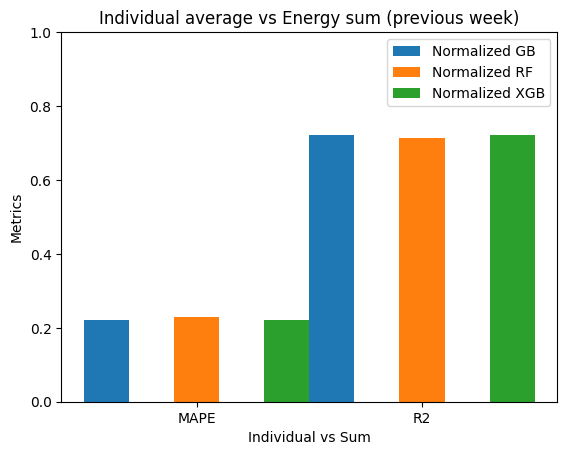

In [141]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[1][3], best_model[1][4]), 0.2, label = 'Normalized GB')
plt.bar(X_axis + 0, (best_model[3][3], best_model[3][4]), 0.2, label = 'Normalized RF')
plt.bar(X_axis + 0.2, (best_model[5][3], best_model[5][4]), 0.2, label = 'Normalized XGB')

plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.title("Individual average vs Energy sum (previous week)")
plt.legend()
plt.show()

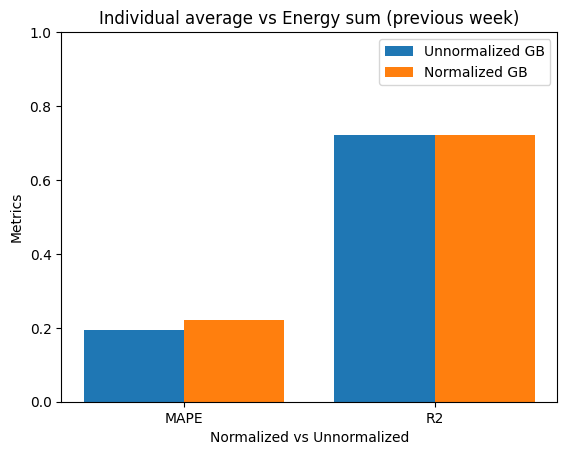

In [142]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[0][3], best_model[0][4]), 0.4, label = 'Denormalized GB')
plt.bar(X_axis + 0.2, (best_model[1][3], best_model[1][4]), 0.4, label = 'Normalized GB')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Normalized vs Denormalied GB")
plt.legend()
plt.show()

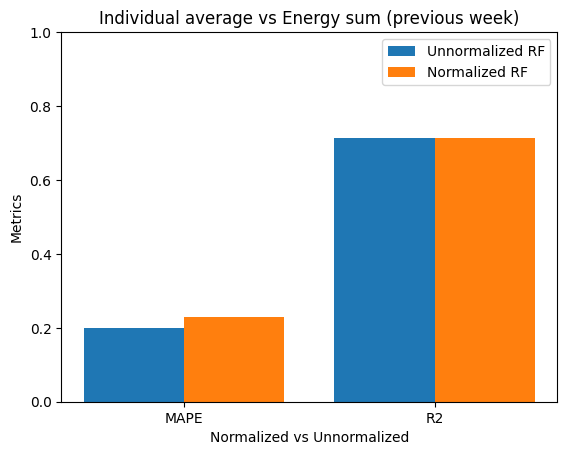

In [143]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[2][3], best_model[2][4]), 0.4, label = 'Denormalized RF')
plt.bar(X_axis + 0.2, (best_model[3][3], best_model[3][4]), 0.4, label = 'Normalized RF')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Normalized vs Denormalied RF")
plt.legend()
plt.show()

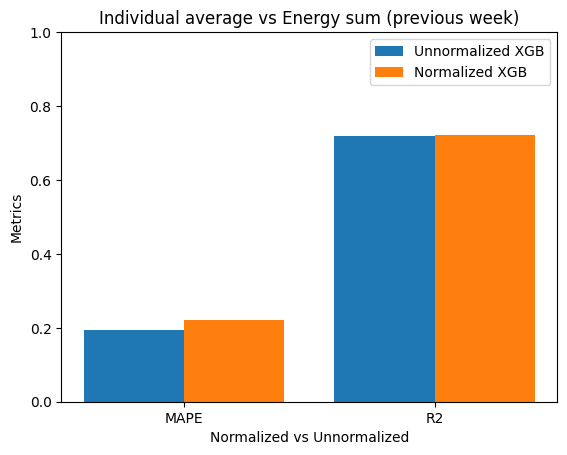

In [144]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[4][3], best_model[4][4]), 0.4, label = 'Denormalized XGB')
plt.bar(X_axis + 0.2, (best_model[5][3], best_model[5][4]), 0.4, label = 'Normalized XGB')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Normalized vs Denormalied XGB")
plt.legend()
plt.show()

## Best model

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params['n_estimators']) + 1,
    model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params['n_estimators']) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos,X_test.columns)
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_test.columns,
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Hyperparameter tuning

In [ ]:
grid = dict()
grid['n_estimators'] = [50, 100, 500]
grid['learning_rate'] = [0.001, 0.01, 0.1, 0.3]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

model = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, random_state=1)
#grid_search = RandomizedSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X, y.values.ravel())

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))